In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Adjusted size
        self.fc2 = nn.Linear(128, 3)
        
        self.dropout = nn.Dropout(0.3)  # Reduce if needed

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(40),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomGrayscale(p=0.3),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Validation transformations (NO augmentations)
transform_val = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset (replace 'train_data_path' and 'val_data_path' with actual paths)
train_dataset = datasets.ImageFolder(root='MLDL_Data_Face-1/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='MLDL_Data_Face-1/val', transform=transform_val)

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import numpy as np

# Define number of folds
num_folds = 5

# Extract image paths and labels from train_dataset
image_paths = np.array(train_dataset.imgs)  # Full dataset image paths
labels = np.array(train_dataset.targets)  # Corresponding labels

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [ ]:
# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"Training on fold {fold + 1}/{num_folds}...")

    # Create subset datasets for this fold
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    # Data Loaders for this fold
    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleCNN().to(device)
    class_counts = [4541, 5453, 4945]
    class_weights = [sum(class_counts) / count for count in class_counts]
    class_weights = torch.FloatTensor(class_weights).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization

    # Early Stopping Parameters
    patience = 6
    best_val_loss = float('inf')
    counter = 0

    # Store Loss and Accuracy
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset counter if validation improves
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break


Training on fold 1/5...


KeyboardInterrupt: 

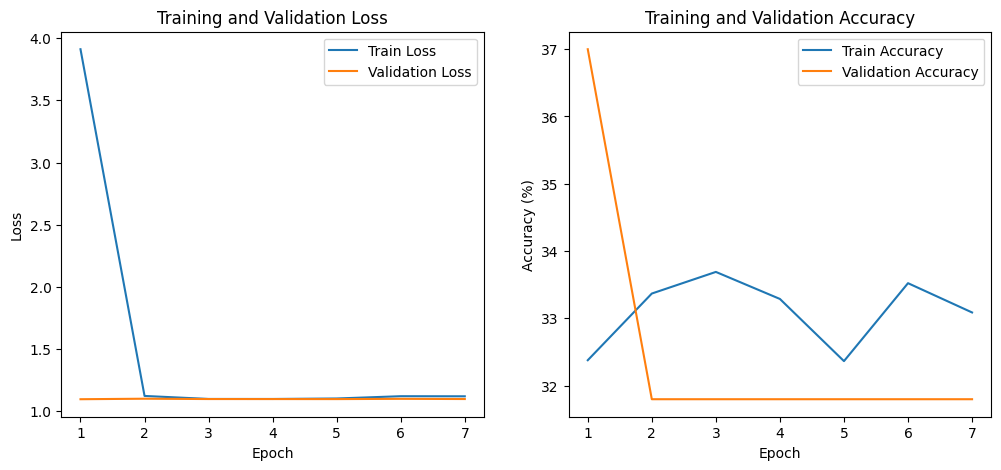

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs) + 1), train_accs, label="Train Accuracy")
plt.plot(range(1, len(val_accs) + 1), val_accs, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy")
plt.legend()

plt.show()

Trial 1: HEAVILY overfitting. Hit early stop at 6 epochs. Adjusting.

In [ ]:
import torch
print(torch.__version__)  # Print the PyTorch version
print(torch.version.cuda)  # Print the installed CUDA version


2.5.1+cu121
12.1
